# Coffea and Awkward

**March 15, 2023 at Beijing**

In [1]:
import awkward as ak
import uproot
import hist
import os
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods.base import NanoEventsArray
from imp import reload #每次修改调用函数后可以更新
import correctionlib, rich
import matplotlib.pyplot as plt
import sys
from coffea.lumi_tools import LumiMask

/tmp/ipykernel_3801380/3220351898.py:8: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload #每次修改调用函数后可以更新


### coffea读文件

In [2]:
import input_file 
reload(input_file)
# zg0_events = input_file.input_file('zg0')#17m
# zg1_events = input_file.input_file('zg1')#17m
# zg2_events = input_file.input_file('zg2')#17m
# zg3_events = input_file.input_file('zg3')#17m
dy_events = input_file.input_file('dy')#17m

dy  is done!


In [3]:
EVENT = {
    # 'zg0': zg0_events,
    # 'zg1': zg1_events,
    # 'zg2': zg2_events,
    # 'zg3': zg3_events,
    'dy': dy_events,
}

## selection

In [4]:
import selection_pu
reload(selection_pu)
event_phodrs = {key: {} for key in EVENT}
event_ABCDs = {key: [] for key in EVENT.keys() if 'data' in key}


for key in EVENT.keys():
    event_variables = []
    event_ABCD_variables = []
    for i in EVENT[key]:
#muon_cut
        if 'data' not in key:
            event_weight = {'event_weight':np.sign(i.Generator.weight)}
            mu0 = selection_pu.muon(i,'num',True)
        elif key == 'dataF':
            murun = selection_pu.muon(i,'run_num','F')
            event_weight =  {'event_weight':'NONE'}
            mu0 = selection_pu.muon(murun,'num',True)
        elif key == 'dataG':
            murun = selection_pu.muon(i,'run_num','G')
            event_weight =  {'event_weight':'NONE'}
            mu0 = selection_pu.muon(murun,'num',True)            
        mu1 = selection_pu.muon(mu0,'trigger','double')
        mu2,event2 = selection_pu.muon(mu1,'cutBasedID','tight')
        mu3 = selection_pu.muon(mu2,'pf','tight')
        mu4 = selection_pu.muon(mu3,'eta','2.4')
        mu5 = selection_pu.muon(mu4,'pt',event2)
        mu6 = selection_pu.muon(mu5,'pid',True)
        mass_mumu = selection_pu.MASS(mu6,'mu')
        mu_mass = selection_pu.muon(mu6,'mass',mass_mumu)
#photon_cut
        # pho1 = selection_pu.photon(mu_mass, 'pt', '30')
        # pho2 = selection_pu.photon(pho1, 'eta', '2.5')
        # pho3 = selection_pu.photon(pho2, 'id', 'C')#tight
        # pho4 = selection_pu.photon(pho3,'prompt',True)
        gen_photon = mu_mass.GenPart[(mu_mass.GenPart.pdgId==22) & mu_mass.GenPart.hasFlags(['isLastCopy',"isPrompt"])]
        photon4_near, photon4_gen_photon_dr = gen_photon.nearest(mu_mass.Photon, axis=1, return_metric=True)
        mask = ak.fill_none(photon4_gen_photon_dr < 0.3, True)
        pho5 = mu_mass[ak.num(mu_mass.Photon[ak.any(mask == True,axis=1)]) >= 1]
        # event_variables.append(selection_pu.VARIABLES(pho5,mass_mumu,mass_gmumu,key,event_weight))
        lg_near, lg_dr = pho5.Photon.nearest(pho5.Muon, axis=1, return_metric=True)
        fsr = selection_pu.muon(pho5,'fsr',lg_dr)
        mass_mumu = selection_pu.MASS(fsr,'mu')
        mass_gmumu = selection_pu.MASS(fsr,'gmumu')
        event_variables.append(selection_pu.VARIABLES(fsr,mass_mumu,mass_gmumu,key,event_weight))
    event_phodrs[key] = event_variables
#    event_ABCDs[key] = event_ABCD_variables
    print(key,'event_phodrs',event_phodrs[key][0])


#60m

dy event_phodrs {'dr_lg': <Array [[1.66], [2.56], ... [1.25], [1.44]] type='1518 * option[var * ?float32]'>, 'photon_pt': <Array [[], [], [], [], ... [], [], [], []] type='1518 * option[var * float32[pa...'>, 'photon_eta': <Array [[], [], [], [], ... [], [], [], []] type='1518 * option[var * float32[pa...'>, 'muon1_pt': <Array [32.6, 110, 69.6, ... 45.7, 50.6, 63.7] type='1518 * ?float32[parameters=...'>, 'muon2_pt': <Array [32.6, 34.9, 30.5, ... 20.4, 27.8, 41.9] type='1518 * ?float32[parameters...'>, 'muon1_eta': <Array [0.934, 0.688, ... -1.19, 0.537] type='1518 * ?float32[parameters={"__doc...'>, 'muon2_eta': <Array [-0.709, -0.307, ... -0.101, 0.0208] type='1518 * ?float32[parameters={"_...'>, 'muon_mass': <Array [88.3, 92.3, 91.7, ... 92.5, 82.9, 93.1] type='1518 * ?float32'>, 'gmumu_mass': <Array [103, 149, 118, 133, ... 123, 94.5, 118] type='1518 * ?float32'>, 'npvsGood': <Array [33, 28, 26, 31, 24, ... 23, 31, 25, 35] type='1518 * ?int32[parameters={...'>, 'Rho_Calo': <Array [

In [5]:
# 样本名称列表
# sample_names = ["zg0","zg1", "zg2", "zg3"]

sample_names = ["dy"]

# 初始化一个字典，用于存储合并后的数据
event_final = {}

# 遍历每个样本名称
for sample_name in sample_names:
    print(sample_name)
    # 初始化一个字典，用于存储当前样本的合并数据
    event_final[sample_name] = {}

    # 获取第一个条目中的信息键
    info_keys = list(event_phodrs[sample_name][0].keys())

    # 遍历每个信息键
    for info_key in info_keys:
        # 从 event_muon_phodrs 中提取当前样本和信息键的数据
        data_to_concatenate = [entry[info_key] for entry in event_phodrs[sample_name]]

        # 使用 ak.concatenate 将数据连接在一起
        event_final[sample_name][info_key] = ak.concatenate(data_to_concatenate)

#print(event_final)


dy


In [6]:
def save_event_dict(event_dict, file_prefix):
    data_subkeys = ['photon_pt', 'photon_eta', 'muon1_pt', 'muon2_pt', 'muon1_eta', 'muon2_eta', 'muon_mass','gmumu_mass','dr_lg','npvsGood','Rho_Calo','Rho_tracker']
    # data_subkeys = ['vidNestedWPBitmap']
    other_subkeys = data_subkeys + ['generator_weight', 'event_weight']
    
    for key, value in event_dict.items():
        subkeys = other_subkeys if 'data' not in key else data_subkeys
        for subkey in subkeys:
            ak.to_parquet(value[subkey], f'{file_prefix}_{key}_{subkey}.parquet')



In [7]:
# 存储数据
#save_event_dict(event_final, 'selection_new/event_final')
# save_event_dict(event_final, 'selection_file/event_final')
save_event_dict(event_final, 'PUbkg_file/event_final')

## 读取文件

In [2]:
def load_event_dict(file_prefix, keys):
    data_subkeys = ['photon_pt', 'photon_eta', 'muon1_pt', 'muon2_pt', 'muon1_eta', 'muon2_eta', 'muon_mass','gmumu_mass','dr_lg','npvsGood','Rho_Calo','Rho_tracker']
#    data_subkeys = ['photon_pt', 'photon_eta', 'muon1_pt', 'muon2_pt', 'muon1_eta', 'muon2_eta', 'muon_mass']
    other_subkeys = data_subkeys + ['generator_weight', 'event_weight']
    
    event_dict = {}
    for key in keys:
        subkeys = other_subkeys if 'data' not in key else data_subkeys
        event_dict[key] = {}
        for subkey in subkeys:
            event_dict[key][subkey] = ak.from_parquet(f'{file_prefix}_{key}_{subkey}.parquet')
    return event_dict
keys = ['zg0', 'zg1', 'zg2','zg3']  # 根据你的实际键来修改这个列表
#keys = ['zg', 'tt', 'zz', 'ww', 'wz']  # 根据你的实际键来修改这个列表
#keys = ['dataC', 'dataD']
# 读取数据
event_final = load_event_dict('PUbkg_file/event_final', keys)


In [3]:
# 将 "data1", "data2", "data3", "data4" 这四个 key 的内容合并为 "data" 这个 key
data_keys = ["zg0", "zg1","zg2","zg3"]
event_final["zg"] = {}

info_keys = list(event_final["zg0"].keys())

# 遍历每个信息键
for info_key in info_keys:
    # 从 event_final 中提取 "data1", "data2", "data3", "data4" 这四个 key 的数据
    data_to_concatenate = [event_final[data_key][info_key] for data_key in data_keys]

    # 使用 ak.concatenate 将数据连接在一起
    event_final["zg"][info_key] = ak.concatenate(data_to_concatenate)

del event_final["zg0"]
del event_final["zg1"]
del event_final["zg2"]
del event_final["zg3"]
event_final

{'zg': {'photon_pt': <Array [[], [14.6], [24.9, ... [327], [252]] type='4220026 * option[var * float32]'>,
  'photon_eta': <Array [[], [-0.358], ... [1.87], [-2.31]] type='4220026 * option[var * float32]'>,
  'muon1_pt': <Array [36.4, 52.8, 56, ... 185, 98.9, 214] type='4220026 * ?float32'>,
  'muon2_pt': <Array [26.9, 38, 30.2, ... 39.9, 84.2, 77] type='4220026 * ?float32'>,
  'muon1_eta': <Array [-1.33, -0.284, ... 1.41, -0.187] type='4220026 * ?float32'>,
  'muon2_eta': <Array [0.58, -0.803, -0.405, ... 2.28, 0.0655] type='4220026 * ?float32'>,
  'muon_mass': <Array [91.3, 92.7, 71.6, ... 95.5, 92.4, 87.1] type='4220026 * ?float32'>,
  'gmumu_mass': <Array [118, 108, 89.2, ... 452, 479, 903] type='4220026 * ?float32'>,
  'dr_lg': <Array [[1.78], [0.715], ... [3.5, 2.46]] type='4220026 * option[var * ?float32]'>,
  'npvsGood': <Array [39, 40, 44, 31, 20, ... 27, 22, 19, 15] type='4220026 * ?int32'>,
  'Rho_Calo': <Array [17.7, 18.3, 22.3, ... 7.67, 7.32, 7.88] type='4220026 * ?float3

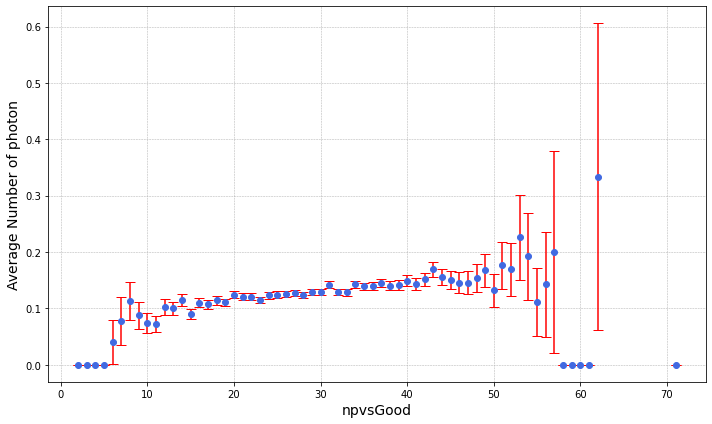

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting the data
# npvsGood_data = ak.to_numpy(event_final['zg']['npvsGood'])  # Convert to numpy array
# photon_pt_count = ak.to_numpy(ak.num(event_final['zg']['photon_pt']))
npvsGood_data = ak.to_numpy(event_final['dy']['npvsGood'])  # Convert to numpy array
photon_pt_count = ak.to_numpy(ak.num(event_final['dy']['photon_pt']))

# Filter out entries where photon_pt_count is greater than 0
filtered_indices = np.where(photon_pt_count >= 0)
npvsGood_data_filtered = npvsGood_data[filtered_indices]
photon_pt_count_filtered = photon_pt_count[filtered_indices]

# Grouping by npvsGood and calculating the mean and standard error of photon_pt_count for each group
unique_npvsGood, indices = np.unique(npvsGood_data_filtered, return_inverse=True)
mean_photon_pt_count = [np.mean(photon_pt_count_filtered[indices == idx]) for idx in range(len(unique_npvsGood))]
std_photon_pt_count = [np.std(photon_pt_count_filtered[indices == idx]) for idx in range(len(unique_npvsGood))]
sample_sizes = [len(photon_pt_count_filtered[indices == idx]) for idx in range(len(unique_npvsGood))]
standard_errors = np.array(std_photon_pt_count) / np.sqrt(sample_sizes)

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(unique_npvsGood, mean_photon_pt_count, yerr=standard_errors, fmt='o', color='royalblue', ecolor='red', capsize=5)
plt.xlabel('npvsGood', fontsize=14)
plt.ylabel('Average Number of photon', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [56]:
ak.max(ak.num(event_final['zg']['photon_pt']))

4

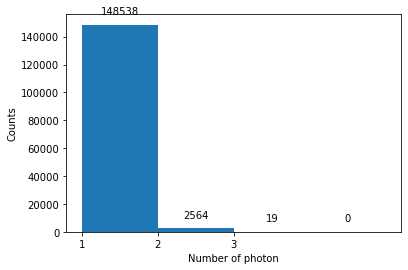

In [60]:
mask = event_final['zg']['npvsGood'] > 40
selected_photon_pt = event_final['zg']['photon_pt'][mask]
num_photon_pt = ak.num(selected_photon_pt)

import boost_histogram as bh

hist = bh.Histogram(bh.axis.Regular(4, 1, 5))  # 3 bins from 1 to 4
hist.fill(num_photon_pt)

# Plotting
plt.bar(hist.axes[0].centers, hist, width=hist.axes[0].widths)

# Setting x-axis ticks to only show integers
plt.xticks(range(1, 4))

# Annotating each bin with its count
for i, count in enumerate(hist):
    plt.text(hist.axes[0].centers[i], count + 0.05 * max(hist), str(int(count)), ha='center')

plt.xlabel('Number of photon')
plt.ylabel('Counts')
plt.show()


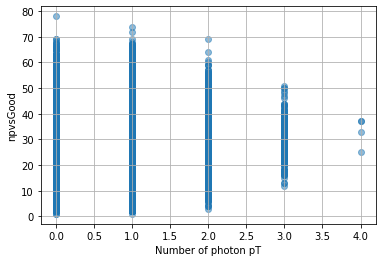

In [63]:
import matplotlib.pyplot as plt

# Extracting the data
x_data = ak.num(event_final['zg']['photon_pt'])
y_data = event_final['zg']['npvsGood']

# Plotting
plt.scatter(x_data, y_data, alpha=0.5)
plt.xlabel('Number of photon pT')
plt.ylabel('npvsGood')
plt.grid(True)
plt.show()


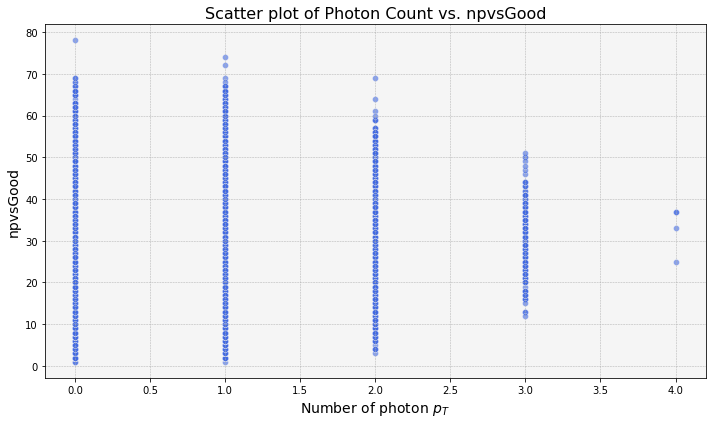

In [64]:
import matplotlib.pyplot as plt

# Extracting the data
x_data = ak.num(event_final['zg']['photon_pt'])
y_data = event_final['zg']['npvsGood']

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting
scatter = ax.scatter(x_data, y_data, alpha=0.6, edgecolors="w", linewidth=0.5, color='royalblue', marker='o')

# Setting labels, title, and grid
ax.set_xlabel('Number of photon $p_T$', fontsize=14)
ax.set_ylabel('npvsGood', fontsize=14)
ax.set_title('Scatter plot of Photon Count vs. npvsGood', fontsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_facecolor('whitesmoke')

# Display the plot
plt.tight_layout()
plt.show()
